
# Clusterização de Pokemóns
## Integrantes:
Alessandra Blücher; 
Bruno Arthur Cesconetto; 
Dennis Zaramelo Felex -
2°C


## Introdução
<br>
Clusterização é a classificação não-supervisionada de dados, formando agrupamentos ou clusters. Ela representa uma das principais etapas de processos de análise de dados, denominada análise de clusters (JAIN et al., 1999).
</br>
<br>
A análise de clusters envolve, portanto, a organização de um conjunto de padrões em clusters, de acordo com alguma medida de similaridade.
</br>
<br>
### O método K-Means
<br>
O método K-Means clusteriza dados na tentativa de separar amostras em N grupos de igual variância, minimizando um critério denominado "inércia". Este algorítimo precisa de um número de clusters especifico e é eficiente ao utilizar-se uma grande quantidade de amostras, sendo utilizado em muitas aplicações e em diferentes áreas. 
</br>
<br>
O algorítimo do método K-Means divide uma amostra em K clusters diferentes, sendo cada um descrito por uma média <i>Uj</i> das variáveis separadas no clustercem questão. As médias são normalmente chamadas de "centróides" do cluster - na maioria das vezes, eles não são pontos que fazem parte das amostras, apesar de estarem no mesmo espaço. O algoritimo K-Means procura definir centroides os quais minimizem a o critério de "inercia".
</br>
<br>
A inércia é dada pela medida de quão coerentes são as variáveis postas num cluster internamente. 
</br>
<br>
•	A inércia assume que os clusters são convexos e isotrópicos, por mais que nem sempre sejam assim. Este coeficiente não é tão preciso quando os clusters forem vastos ou muito heterogêneos entre si (diferentes formas e tamanhos); 
</br>
<br>
•	A inercia não é uma métrica normalizada: sabe-se que valores baixos são os melhores e zeros constituem o caso ideal. Porém, em espaços com muitas dimensões, as distancias euclidianas tendem a se tornar “infladas”. Executar algoritmos de redução de dimensões antes de realizar a clusterização por K-Means, como o PCA, pode atenuar este problema e aumentar a velocidade dos cálculos.     
</br>

# Objetivos
<br>
O trabalho em questão buscará classificar os clusters resultantes de um dataframe de Pokémons clusterizado pelo método K-Means. Encontrando as características que definem cada cluster, é possível definir quais as habilidades e fraquezas dos pokémons integrantes de cada um deles, o que é útil para as batalhas propostas nos jogos da franquia. 
</br>

In [1]:
#importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #para gráficos estilizados
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#lendo os dataframes
pokemons = pd.read_json('pokedex.json')
itens = pd.read_json('items.json')
habilidades = pd.read_json('skills.json')
tipos = pd.read_json('types.json')

In [3]:
#abrindo o dicionário contido em pokemons.base e adicionando novas colunas ao dataframe, uma para cada atributo do dicionário: 

#criando listas as quais armazenam os valores de um mesmo atributo
Attack= []
Defense = []
HP = []
SpAtk = []
SpDef = []
Speed = []

#percorrendo o dicionário e adicionando os valores às listas
for idx, row in pokemons['base'].iteritems(): #para cada index i, em cada linha dessa coluna base...
    l=row.keys()   #l é uma variável que contempla as chaves do dicionário

    if 'Attack' in l:   #quando a variável assume a chave ataque
        Attack.append(row['Attack']) #adicionamos seu valor a lista externa "ataque"
    else:
        Attack.append(None) #caso não haja, pass
    if 'Defense' in l:
        Defense.append(row['Defense'])
    else:
        Defense.append(None)
    if 'HP' in l:
        HP.append(row['HP'])
    else:
        HP.append(None)
    if 'Sp.Atk' in l:
        SpAtk.append(row['Sp.Atk'])
    else:
        SpAtk.append(None)
    if 'Sp.Def' in l:
        SpDef.append(row['Sp.Def'])
    else:
        SpDef.append(None) 
    if 'Speed' in l:
        Speed.append(row['Speed'])
    else:
        Speed.append(None)
    
#criando as novas colunas com os valores separados
pokemons['Attack']=Attack
pokemons['Defense']=Defense
pokemons['HP']=HP
pokemons['Sp.Atk']=SpAtk
pokemons['Sp.Def']=SpDef
pokemons['Speed']=Speed


In [4]:
#selecionando as colunas de interesse do dataframe
df = pokemons[['ename','type','Attack','Defense','HP','Sp.Atk','Sp.Def','Speed']]

#renomenando as colunas
df.columns = ['nome','tipo','ataque','defesa','HP','spe.atk','spe.def','velocidade']

df.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60
2,Venusaur,"[草, 毒]",82,83,80,100,100,80
3,Charmander,[炎],52,43,39,60,50,65
4,Charmeleon,[炎],64,58,58,80,65,80


## Explicação e Exemplos de aplicação de clusterização

Referência teórica para diferentes métodos de clusterzação: <br>
http://scikit-learn.org/stable/modules/clustering.html</br>

Exemplos de clusterização por K-means:<br> http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html</br>
<br>http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py</br>

# Verificando o número ideal de clusters

O método de distorção visa obter o número ideal de clusters ao se comparar o comportamento dos clusters para n clusters de uma mesma amostra. Quando a distorção passar a ter baixa variabilidade, mesmo aumentando o número de clusters, tem-se um número bom de divisões. Mais que isso torna os clusters basicamente singulares, ou seja, chegando a apenas 1 característica em específico os definindo e, menos que o ideal, deixa-os muito heterogêneos.

In [5]:
#guarando os dados em variáveis
v1 = df['ataque']
v2 = df['defesa']
v3 = df['HP']
v4 = df['spe.atk']
v5 = df['spe.def']
v6 = df['velocidade']

#as variáveis serão componentes de uma matriz
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

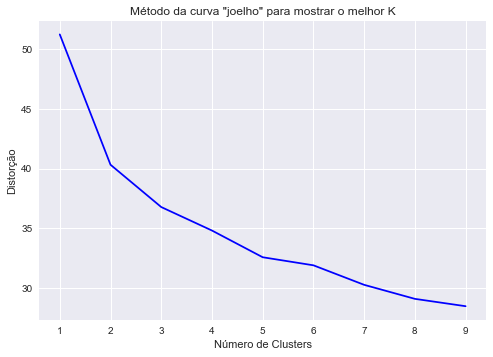

In [6]:
#kmeans determina o k ideal
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

#plotando 
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Distorção')
plt.title('Método da curva "joelho" para mostrar o melhor K')
plt.show()
 

Pelo gráfico acima, nota-se que 4 clusters é um número razoável para a divisão do dataframe de Pokemóns utilizado.

# Clusterizando o Dataframe

Será considerada na clusterização 4 variáveis: ataque, defesa, hp e velocidade; <br>
Como um gráfico 3D adimite apenas 3 variáveis, vamos "quebrar" a quarta variável em faixas e, a partir desta delimitação, será plotado o gráfico com os clusters, visualizando os pontos definidos pelas variáveis restantes dos Pokemóns os quais se encaixarem na delimitação em questão.</br>

In [7]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
df.loc[:,'cluster'] = kmeans.labels_ #indentificando cada um dos pokemóns por seu cluster numa nova coluna, em caso de futuro material de análise

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Função-Plot do fit realizado pelo Kmeans 

In [8]:
#função que plota o gráfico com os clusters


def showcluster(info, k, color, titulo):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(titulo)
    ax.set_xlabel(str(info[0].name))
    ax.set_ylabel(str(info[1].name))
    ax.set_zlabel(str(info[2].name))
    if k!=len(color):
        print ("numero de cores diferente de clusters", len(color),k)
        return 0
    for i in range(0,k):
        ax.scatter(info[0][df.cluster==i], info[1][df.cluster==i], info[2][df.cluster==i], marker='o', c=color[i])
    return fig

colors = ['red','green','blue','purple']



# Clusterização com base na delimitação de uma das variáveis

### Para dado poder de ataque, como as outras três variáveis são distribuídas?

In [9]:
#ataques baixos
ataque40 = df[df.ataque<=40]

#variáveis que comporão a matriz para o fit (cada variável contém os valores de uma das colunas de interesse)
v1 = ataque40['ataque']
v2 = ataque40['defesa']
v3 = ataque40['HP']
v4 = ataque40['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4) #arranjo numa matriz

In [10]:
kmeans = KMeans(n_clusters=4).fit(X) #clusterização realizada pelo módulo python
y_kmeans = kmeans.predict(X)
ataque40.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
#ataques médios
ataque80 = df[(df['ataque']>40) & (df['ataque'] <= 80)]
#repetindo o processo de clusterização
v1 = ataque80['ataque']
v2 = ataque80['defesa']
v3 = ataque80['HP']
v4 = ataque80['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [12]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
ataque80.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
#ataques fortes
ataquef = df[df['ataque'] > 80]
#repetindo o processo de clusterização
v1 = ataquef['ataque']
v2 = ataquef['defesa']
v3 = ataquef['HP']
v4 = ataquef['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [14]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
ataquef.loc[:,'cluster'] = kmeans.labels_


C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


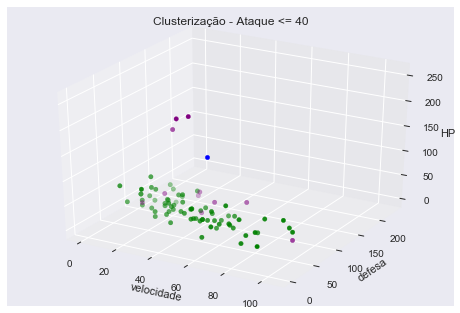

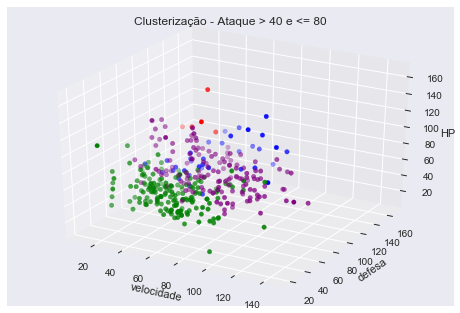

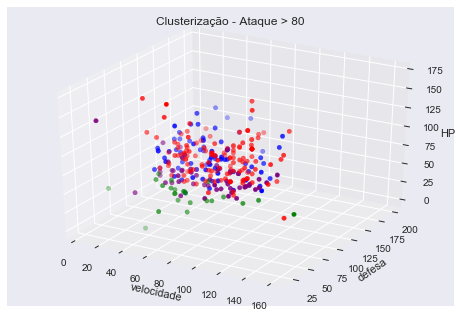

In [15]:
#área de plotagem
fig = plt.figure(figsize=plt.figaspect(0.5))

plot = showcluster([ataque40.velocidade,ataque40.defesa,ataque40.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Ataque <= 40')

plot = showcluster([ataque80.velocidade,ataque80.defesa,ataque80.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Ataque > 40 e <= 80')

plot = showcluster([ataquef.velocidade,ataquef.defesa,ataquef.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Ataque > 80')

plt.show()


### Separando os dataframes de ataque por clusters

In [16]:
#ataques fracos
a400 = ataque40[ataque40.cluster==0]
a401 = ataque40[ataque40.cluster==1]
a402 = ataque40[ataque40.cluster==2]
a403 = ataque40[ataque40.cluster==3]


In [17]:
#ataques médios
a800 = ataque80[ataque80.cluster==0]
a801 = ataque80[ataque80.cluster==1]
a802 = ataque80[ataque80.cluster==2]
a803 = ataque80[ataque80.cluster==3]


In [18]:
#ataques fortes
af0 = ataquef[ataquef.cluster==0]
af1 = ataquef[ataquef.cluster==1]
af2 = ataquef[ataquef.cluster==2]
af3 = ataquef[ataquef.cluster==3]


### Porcentagem dos Pokemóns clusterizados por cluster

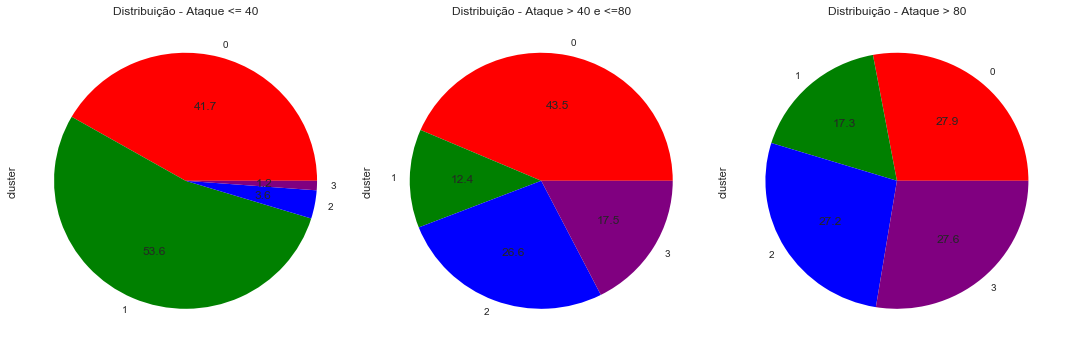

In [19]:
#value_counts
a40vc=(ataque40.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
a80vc=(ataque80.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
afvc = (ataquef.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#área de plotagem
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = a40vc.plot(kind='pie',title='Distribuição - Ataque <= 40',autopct='%.1f', colors=colors)

plt.subplot(132)
plot = a80vc.plot(kind='pie',title='Distribuição - Ataque > 40 e <=80',autopct='%.1f', colors=colors)

plt.subplot(133)
plot = afvc.plot(kind='pie',title='Distribuição - Ataque > 80',autopct='%.1f', colors=colors)

plt.tight_layout()
plt.show()


### Para dada capacidade de defesa, como as outras três variáveis são distribuídas?

In [20]:
#defesas baixas
defesa40 = df[df.defesa<=40]

#repetindo o processo de clusterização
v1 = defesa40['ataque']
v2 = defesa40['defesa']
v3 = defesa40['HP']
v4 = defesa40['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [21]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesa40.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
#defesas médias
defesa80 = df[(df['defesa']>40) & (df['defesa'] <= 80)]
#repetindo o processo de clusterização
v1 = defesa80['ataque']
v2 = defesa80['defesa']
v3 = defesa80['HP']
v4 = defesa80['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [23]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesa80.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
#defesas fortes
defesaf = df[df['defesa'] > 80]
#repetindo o processo de clusterização
v1 = defesaf['ataque']
v2 = defesaf['defesa']
v3 = defesaf['HP']
v4 = defesaf['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [25]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesaf.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


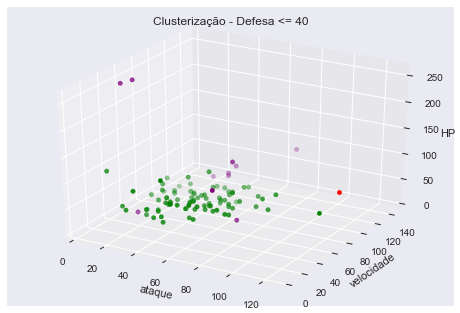

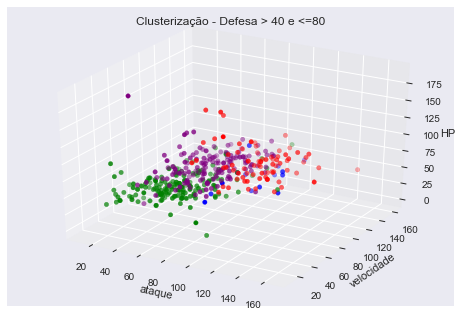

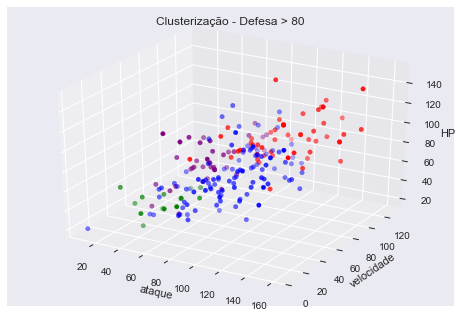

In [26]:
#área de plotagem
fig = plt.figure(figsize=plt.figaspect(0.5))

plot = showcluster([defesa40.ataque,defesa40.velocidade,defesa40.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Defesa <= 40')

plot = showcluster([defesa80.ataque,defesa80.velocidade,defesa80.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Defesa > 40 e <=80')

plot = showcluster([defesaf.ataque,defesaf.velocidade,defesaf.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Defesa > 80')

plt.show()

### Separando os dataframes de defesa por clusters

In [27]:
#defesas fracas
d400 = defesa40[defesa40.cluster==0]
d401 = defesa40[defesa40.cluster==1]
d402 = defesa40[defesa40.cluster==2]
d403 = defesa40[defesa40.cluster==3]


In [28]:
#defesas médias
d800 = defesa80[defesa80.cluster==0]
d801 = defesa80[defesa80.cluster==1]
d802 = defesa80[defesa80.cluster==2]
d803 = defesa80[defesa80.cluster==3]


In [29]:
#defesas fortes
df0 = defesaf[defesaf.cluster==0]
df1 = defesaf[defesaf.cluster==1]
df2 = defesaf[defesaf.cluster==2]
df3 = defesaf[defesaf.cluster==3]


### Porcentagem dos Pokemóns clusterizados por cluster

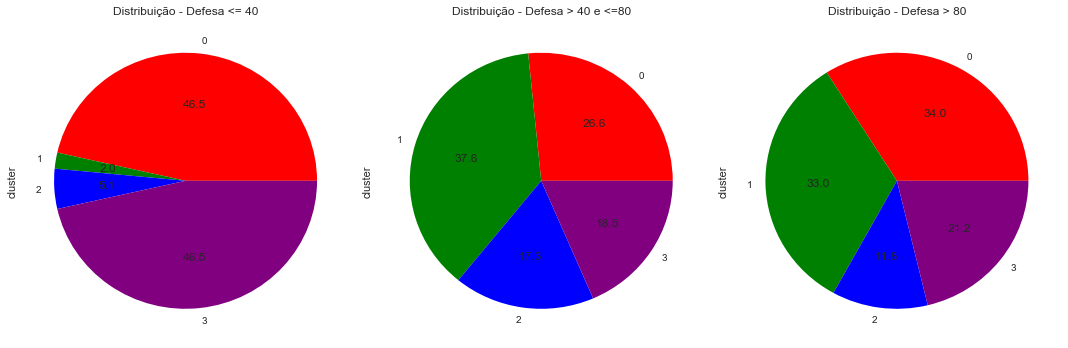

In [30]:
#value_counts
d40vc=(defesa40.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
d80vc=(defesa80.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
dfvc=(defesaf.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#área de plotagem
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = d40vc.plot(kind='pie',title='Distribuição - Defesa <= 40',autopct='%.1f', colors=colors)

plt.subplot(132)
plot = d80vc.plot(kind='pie',title='Distribuição - Defesa > 40 e <=80',autopct='%.1f', colors=colors)

plt.subplot(133)
plot = dfvc.plot(kind='pie',title='Distribuição - Defesa > 80',autopct='%.1f', colors=colors)

plt.tight_layout()
plt.show()


   ### Para dado nível de HP, como as outras três variáveis são distribuídas?

In [31]:
#HP baixo
HP40 = df[df.HP<=40]

#repetindo o processo de clusterização
v1 = HP40['ataque']
v2 = HP40['defesa']
v3 = HP40['HP']
v4 = HP40['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [32]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HP40.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
#HP médio
HP80 = df[(df['HP']>40) & (df['HP'] <= 80)]
#repetindo o processo de clusterização
v1 = HP80['ataque']
v2 = HP80['defesa']
v3 = HP80['HP']
v4 = HP80['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [34]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HP80.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [35]:
#HP alto
HPa = df[df['HP'] > 80]
#repetindo o processo de clusterização
v1 = HPa['ataque']
v2 = HPa['defesa']
v3 = HPa['HP']
v4 = HPa['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [36]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HPa.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


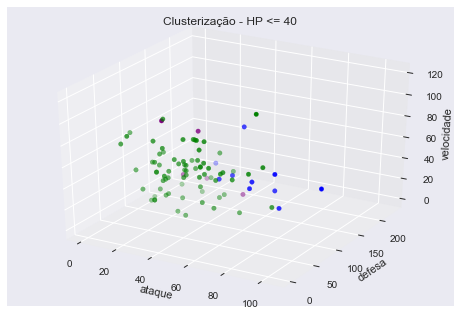

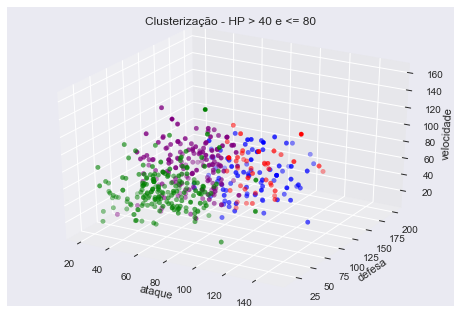

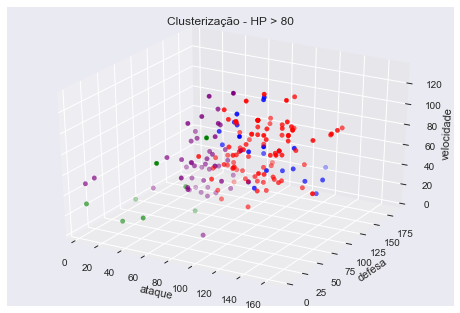

In [37]:
#área de plotagem

fig = plt.figure(figsize=plt.figaspect(0.5))

plot = showcluster([HP40.ataque,HP40.defesa,HP40.velocidade],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - HP <= 40')

plot = showcluster([HP80.ataque,HP80.defesa,HP80.velocidade],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - HP > 40 e <= 80')

plot = showcluster([HPa.ataque,HPa.defesa,HPa.velocidade],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - HP > 80')

plt.show()


### Separando os dataframes de HP por clusters

In [38]:
#HP Baixo
hp400 = HP40[HP40.cluster==0]
hp401 = HP40[HP40.cluster==1]
hp402 = HP40[HP40.cluster==2]
hp403 = HP40[HP40.cluster==3]


In [39]:
#HP Médio
hp800 = HP80[HP80.cluster==0]
hp801 = HP80[HP80.cluster==1]
hp802 = HP80[HP80.cluster==2]
hp803 = HP80[HP80.cluster==3]


In [40]:
#HP Alto
hpa0 = HPa[HPa.cluster==0]
hpa1 = HPa[HPa.cluster==1]
hpa2 = HPa[HPa.cluster==2]
hpa3 = HPa[HPa.cluster==3]


### Porcentagem dos Pokemóns clusterizados por cluster

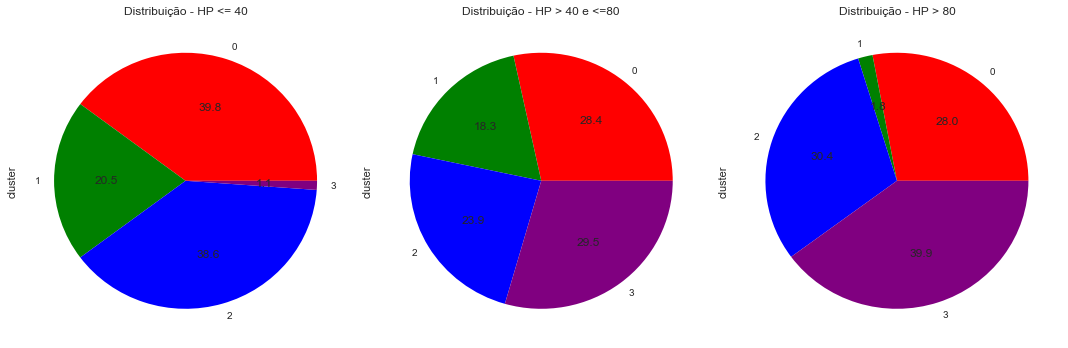

In [41]:
#value_counts
hp40vc=(HP40.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
hp80vc=(HP80.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
hpavc=(HPa.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#área de plotagem
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = hp40vc.plot(kind='pie',title='Distribuição - HP <= 40',autopct='%.1f', colors=colors)

plt.subplot(132)
plot = hp80vc.plot(kind='pie',title='Distribuição - HP > 40 e <=80',autopct='%.1f', colors=colors)

plt.subplot(133)
plot = hpavc.plot(kind='pie',title='Distribuição - HP > 80',autopct='%.1f', colors=colors)

plt.tight_layout()
plt.show()


### Para dada velocidade do pokemón, como as outras três variáveis são distribuídas?

In [42]:
#Velocidade baixa
V40 = df[df.velocidade<=40]

#repetindo o processo de clusterização
v1 = V40['ataque']
v2 = V40['defesa']
v3 = V40['HP']
v4 = V40['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [43]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
V40.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
#Velocidade média
V80 = df[(df['velocidade']>40) & (df['velocidade'] <= 80)]
#repetindo o processo de clusterização
v1 = V80['ataque']
v2 = V80['defesa']
v3 = V80['HP']
v4 = V80['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [45]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
V80.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
#Velocidade alta
Va = df[df['velocidade'] > 80]
#repetindo o processo de clusterização
v1 = Va['ataque']
v2 = Va['defesa']
v3 = Va['HP']
v4 = Va['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [47]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
Va.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


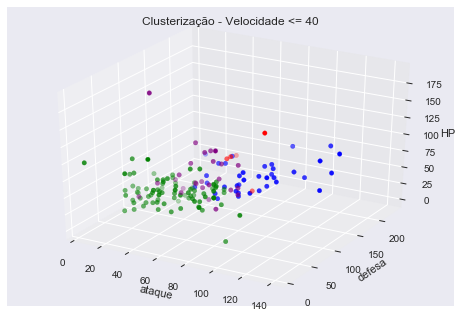

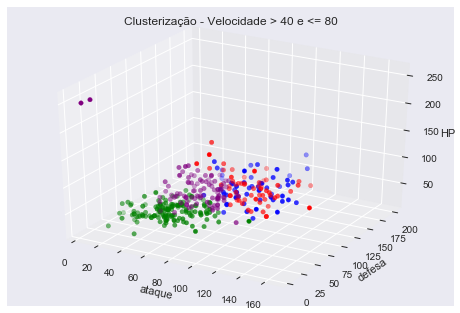

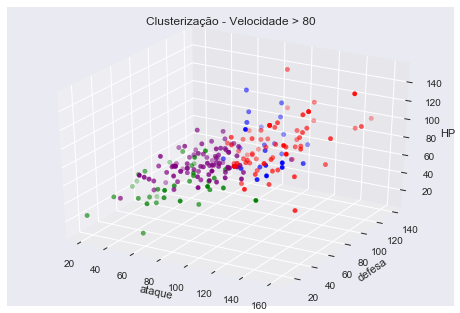

In [48]:
#área de plotagem
fig = plt.figure(figsize=plt.figaspect(0.5))

plot = showcluster([V40.ataque,V40.defesa,V40.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Velocidade <= 40')

plot = showcluster([V80.ataque,V80.defesa,V80.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Velocidade > 40 e <= 80')

plot = showcluster([Va.ataque,Va.defesa,Va.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Velocidade > 80')

plt.show()

### Separando os dataframes de defesa por clusters

In [49]:
#Velocidades baixas
v400 = V40[V40.cluster==0]
v401 = V40[V40.cluster==1]
v402 = V40[V40.cluster==2]
v403 = V40[V40.cluster==3]


In [50]:
#Velocidades médias
v800 = V80[V80.cluster==0]
v801 = V80[V80.cluster==1]
v802 = V80[V80.cluster==2]
v803 = V80[V80.cluster==3]


In [51]:
#Velocidades altas
va0 = Va[Va.cluster==0]
va1 = Va[Va.cluster==1]
va2 = Va[Va.cluster==2]
va3 = Va[Va.cluster==3]


### Porcentagem dos Pokemóns clusterizados por cluster

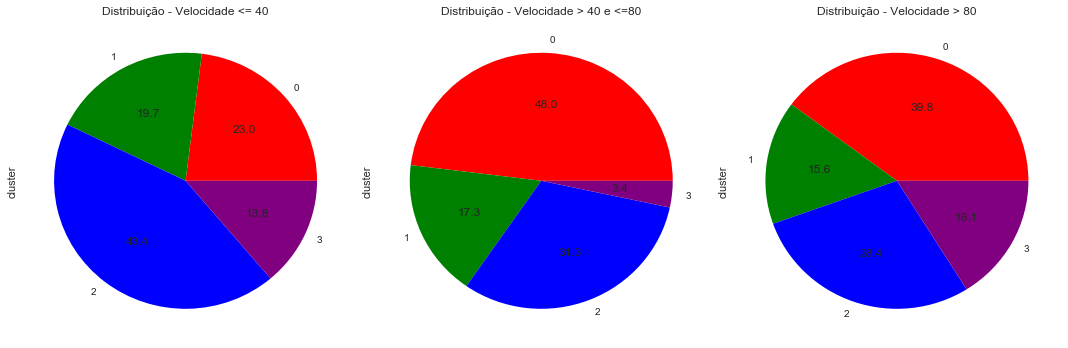

In [52]:
#value_counts
v40vc=(V40.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
v80vc=(V80.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
vavc=(Va.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#área de plotagem

fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = v40vc.plot(kind='pie',title='Distribuição - Velocidade <= 40',autopct='%.1f', colors=colors)

plt.subplot(132)
plot = v80vc.plot(kind='pie',title='Distribuição - Velocidade > 40 e <=80',autopct='%.1f', colors=colors)

plt.subplot(133)
plot = vavc.plot(kind='pie',title='Distribuição - Velocidade > 80',autopct='%.1f', colors=colors)

plt.tight_layout()
plt.show()


## Por fim, será analisado o dataframe completo, também filtrado por cluster:

In [53]:
#filtragem
cluster0 = df[df.cluster==0]
cluster1 = df[df.cluster==1]
cluster2 = df[df.cluster==2]
cluster3 = df[df.cluster==3]

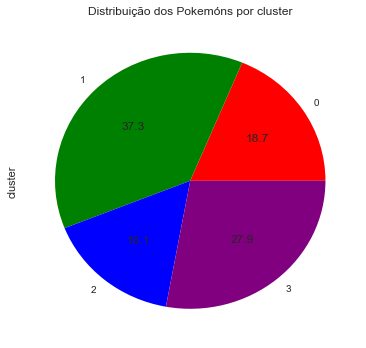

In [54]:
#value_counts
dfvc=(df.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#plot
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = dfvc.plot(kind='pie',title='Distribuição dos Pokemóns por cluster',autopct='%.1f', colors=colors)
plt.tight_layout()
plt.show()

# Cluster 0

In [55]:
cluster0

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
30,Nidoqueen,"[毒, 地上]",92,87,90,75,85,76,0
33,Nidoking,"[毒, 地上]",102,77,81,85,75,85,0
58,Arcanine,[炎],110,80,90,100,80,95,0
67,Machamp,[格斗],130,80,90,65,85,55,0
70,Victreebel,"[草, 毒]",105,65,80,100,70,70,0
79,Slowbro,"[水, 超能]",75,110,95,100,80,30,0
88,Muk,[毒],105,75,105,65,100,50,0
102,Exeggutor,"[草, 超能]",95,85,95,125,65,55,0
129,Gyarados,"[水, 飞行]",125,79,95,60,100,81,0
130,Lapras,"[水, 冰]",85,80,130,85,95,60,0


In [56]:
print('A média das variáveis utilizadas dos Pokémons do cluster 0 é de:', (cluster0.ataque.mean()+cluster0.defesa.mean()+cluster0.HP.mean()+cluster0.velocidade.mean())/4)
print('O desvio padrão de ataque dos Pokémons do cluster 0 é de:', cluster0.ataque.std())
print('O desvio padrão de defesa dos Pokémons do cluster 0 é de:', cluster0.defesa.std())
print('O desvio padrão de HP dos Pokémons do cluster 0 é de:', cluster0.HP.std())
print('O desvio padrão de velocidade dos Pokémons do cluster 0 é de:', cluster0.velocidade.std())
print('O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster 0 é de:', (cluster0.ataque.std()+cluster0.defesa.std()+cluster0.HP.std()+cluster0.velocidade.std())/4)

A média das variáveis utilizadas dos Pokémons do cluster 0 é de: 92.09444444444445
O desvio padrão de ataque dos Pokémons do cluster 0 é de: 18.820733541916802
O desvio padrão de defesa dos Pokémons do cluster 0 é de: 18.776721883429833
O desvio padrão de HP dos Pokémons do cluster 0 é de: 21.185818759926853
O desvio padrão de velocidade dos Pokémons do cluster 0 é de: 23.54881548804514
O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster 0 é de: 20.58302241832966


# Cluster 1

In [57]:
cluster1

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45,1
3,Charmander,[炎],52,43,39,60,50,65,1
6,Squirtle,[水],48,65,44,50,64,43,1
9,Caterpie,[虫],30,35,45,20,20,45,1
10,Metapod,[虫],20,55,50,25,25,30,1
12,Weedle,"[虫, 毒]",35,30,40,20,20,50,1
13,Kakuna,"[虫, 毒]",25,50,45,25,25,35,1
14,Beedrill,"[虫, 毒]",90,40,65,45,80,75,1
15,Pidgey,"[一般, 飞行]",45,40,40,35,35,56,1
16,Pidgeotto,"[一般, 飞行]",60,55,63,50,50,71,1


In [58]:
print('A média das variáveis utilizadas dos Pokémons do cluster 1 é de:', (cluster1.ataque.mean()+cluster1.defesa.mean()+cluster1.HP.mean()+cluster1.velocidade.mean())/4)
print('O desvio padrão de ataque dos Pokémons do cluster 1 é de:', cluster1.ataque.std())
print('O desvio padrão de defesa dos Pokémons do cluster 1 é de:', cluster1.defesa.std())
print('O desvio padrão de HP dos Pokémons do cluster 1 é de:', cluster1.HP.std())
print('O desvio padrão de velocidade dos Pokémons do cluster 1 é de:', cluster1.velocidade.std())
print('O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster 1 é de:', (cluster1.ataque.std()+cluster1.defesa.std()+cluster1.HP.std()+cluster1.velocidade.std())/4)

A média das variáveis utilizadas dos Pokémons do cluster 1 é de: 52.02509293680297
O desvio padrão de ataque dos Pokémons do cluster 1 é de: 19.463229151905583
O desvio padrão de defesa dos Pokémons do cluster 1 é de: 15.554530960162932
O desvio padrão de HP dos Pokémons do cluster 1 é de: 14.517257417089992
O desvio padrão de velocidade dos Pokémons do cluster 1 é de: 22.942084930196494
O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster 1 é de: 18.11927561483875


# Cluster 2

In [59]:
cluster2

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
8,Blastoise,[水],83,100,79,85,105,78,2
27,Sandslash,[地上],100,110,75,45,55,65,2
46,Parasect,"[虫, 草]",95,80,60,60,80,30,2
61,Poliwrath,"[水, 格斗]",95,95,90,70,90,70,2
66,Machoke,[格斗],100,70,80,50,60,45,2
73,Geodude,"[岩石, 地上]",80,100,40,30,30,20,2
74,Graveler,"[岩石, 地上]",95,115,55,45,45,35,2
75,Golem,"[岩石, 地上]",120,130,80,55,65,45,2
84,Dodrio,"[一般, 飞行]",110,70,60,60,60,100,2
89,Shellder,[水],65,100,30,45,25,40,2


In [60]:
print('A média das variáveis utilizadas dos Pokémons do cluster 2 é de:', (cluster2.ataque.mean()+cluster2.defesa.mean()+cluster2.HP.mean()+cluster2.velocidade.mean())/4)
print('O desvio padrão de ataque dos Pokémons do cluster 2 é de:', cluster2.ataque.std())
print('O desvio padrão de defesa dos Pokémons do cluster 2 é de:', cluster2.defesa.std())
print('O desvio padrão de HP dos Pokémons do cluster 2 é de:', cluster2.HP.std())
print('O desvio padrão de velocidade dos Pokémons do cluster 2 é de:', cluster2.velocidade.std())
print('O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster 2 é de:', (cluster2.ataque.std()+cluster2.defesa.std()+cluster2.HP.std()+cluster2.velocidade.std())/4)

A média das variáveis utilizadas dos Pokémons do cluster 2 é de: 83.02155172413794
O desvio padrão de ataque dos Pokémons do cluster 2 é de: 23.092998543046445
O desvio padrão de defesa dos Pokémons do cluster 2 é de: 29.379258918031162
O desvio padrão de HP dos Pokémons do cluster 2 é de: 19.752947515047815
O desvio padrão de velocidade dos Pokémons do cluster 2 é de: 26.27291175439017
O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster 2 é de: 24.624529182628894


# Cluster 3

In [61]:
cluster3

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60,3
2,Venusaur,"[草, 毒]",82,83,80,100,100,80,3
4,Charmeleon,[炎],64,58,58,80,65,80,3
5,Charizard,"[炎, 飞行]",84,78,78,109,85,100,3
7,Wartortle,[水],63,80,59,65,80,58,3
11,Butterfree,"[虫, 飞行]",45,50,60,90,80,70,3
17,Pidgeot,"[一般, 飞行]",80,75,83,70,70,101,3
21,Fearow,"[一般, 飞行]",90,65,65,61,61,100,3
23,Arbok,[毒],85,69,60,65,79,80,3
25,Raichu,[电],90,55,60,90,80,110,3


In [62]:
print('A média das variáveis utilizadas dos Pokémons do cluster 3 é de:', (cluster3.ataque.mean()+cluster3.defesa.mean()+cluster3.HP.mean()+cluster3.velocidade.mean())/4)
print('O desvio padrão de ataque dos Pokémons do cluster 3 é de:', cluster3.ataque.std())
print('O desvio padrão de defesa dos Pokémons do cluster 3 é de:', cluster3.defesa.std())
print('O desvio padrão de HP dos Pokémons do cluster 3 é de:', cluster3.HP.std())
print('O desvio padrão de velocidade dos Pokémons do cluster 3 é de:', cluster3.velocidade.std())
print('O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster 3 é de:', (cluster3.ataque.std()+cluster3.defesa.std()+cluster3.HP.std()+cluster3.velocidade.std())/4)


A média das variáveis utilizadas dos Pokémons do cluster 3 é de: 71.74751243781094
O desvio padrão de ataque dos Pokémons do cluster 3 é de: 16.547139056201637
O desvio padrão de defesa dos Pokémons do cluster 3 é de: 17.466310144096024
O desvio padrão de HP dos Pokémons do cluster 3 é de: 26.186483923935015
O desvio padrão de velocidade dos Pokémons do cluster 3 é de: 27.4824512075999
O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster 3 é de: 21.92059608295814
